# **Assignment 05**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
from tqdm import tqdm
from sklearn.metrics import multilabel_confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels

In [0]:
# mounting google drive to colab
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !cp 'drive/My Drive/vgg16_ft.pth' './'

In [0]:
# unzipping the dataset
!unzip 'drive/My Drive/A_05_Part_02_Dataset'

In [2]:
x = os.listdir('A_05_Part_02_Dataset/Test')
print(len(x))

1


In [0]:
!mkdir 'A_05_Part_02_Dataset/Test'

In [0]:
!mv 'A_05_Part_02_Dataset/noLabel' 'A_05_Part_02_Dataset/Test'

### Load Dataset usign torchvision image loader

In [0]:
#Define transforms for the training data and testing data
def loadAndTransformData(path, trainName, testName, validName):
  train_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

  test_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
  
  valid_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

  #pass transform here-in
  train_data = datasets.ImageFolder(path + trainName, transform=train_transforms)
  test_data = datasets.ImageFolder(path + testName, transform=test_transforms)
  valid_data = datasets.ImageFolder(path + validName, transform=valid_transforms)

  #data loaders
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers= 4)
  testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers= 4)
  validloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True, num_workers= 4)
  
  print("Classes: ")
  class_names = train_data.classes
  print(class_names)
  return trainloader, testloader, validloader,class_names

def oneHotEncode(targets):
  onehot = []
  for x in targets:
    if x == 0: 
      onehot.append([1,0,1])
    elif x == 2:
      onehot.append([0,0,1])
    else:
      onehot.append([0,1,0])
  onehot = torch.tensor(onehot)
  return onehot


def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  plt.axis('off')
  plt.imshow(inp)
  if title is not None:
      plt.title(title)

def show_databatch(inputs, classes, class_names):
  out = torchvision.utils.make_grid(inputs)
  imshow(out, title=[class_names[x] for x in classes])

def train(model, trainloader, validloader, Epochs, criterion, optimizer, device, modelFileName):
  validAcc = 0
  acc = []
  errors = []
  trainAcc = []
  for epoch in range(Epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      trainTotal = 0
      trainCorrect = 0
      pbar = tqdm(enumerate(trainloader))
      for i, data in pbar:
          # get the inputs
          inputs, labels = data
          labels = oneHotEncode(labels)*1.0
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
          # because PyTorch accumulates the gradients on subsequent backward passes. 
          # This is convenient while training RNNs. 
          # So, the default action is to accumulate the gradients on every loss.backward() call

          # forward + backward + optimize
          outputs = model(inputs)               #----> forward pass
          loss = criterion(outputs, labels)   #----> compute loss
          loss.backward()                     #----> backward pass
          optimizer.step()                    #----> weights update

          # print statistics
          running_loss += loss.item()
          out = torch.sigmoid(outputs)
          out = (out >= 0.5).float()
          trainTotal += labels.size(0)
          pred1 = out.tolist()
          true1 = labels.tolist()
          for i in range(len(true1)):
            if pred1[i] == true1[i]:
              trainCorrect +=1
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))
      # validation accuracy
      validAcc,true,pred = accuracy(model, validloader, device)
      acc.append(validAcc)
      trainAcc.append(trainCorrect/trainTotal)
      errors.append(running_loss)
      print(f'Validation Accuracy of the epoch: {epoch} on the validation images is {validAcc}')    
      torch.save(model.state_dict(), modelFileName)

  print('Finished Training')
  return errors, acc, trainAcc

def plotError(errors,acc):
  acc = np.array(acc)
  errors = np.array(errors)/100
  validErr = 1 - acc    
  plt.plot(errors,'b',label='Train Error')
  plt.plot(validErr,'r', label = 'Validation Error')
  plt.title('Train and Validation Errors')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.show

def plotAcc(acc,trainAcc):
  acc = np.array(acc)
  trainAcc = np.array(trainAcc)
  plt.plot(trainAcc,'b',label='Train Accuracy')
  plt.plot(acc,'r', label = 'Validation Accuracy')
  plt.title('Train and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show

def prediction(model,testloader,device):
  trueLabel = []
  prediction = []
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          labels = oneHotEncode(labels)*1.0
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          outputs = torch.sigmoid(outputs)
          out = (outputs >= 0.5).float()
          trueLabel.append(labels)
          prediction.append(out)
  return torch.cat(trueLabel), torch.cat(prediction)

def accuracy(model, testloader,device):
  correct = 0
  total = 0
  true, pred = prediction(model, testloader, device)
  total = true.size(0)
  pred1 = pred.tolist()
  true1 = true.tolist()
  for i in range(len(true1)):
    if pred1[i] == true1[i]:
      correct+=1
  acc = correct / total
  return acc,true,pred

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    multilabels = [[classes[1]+' + '+classes[2], classes[0]], [classes[0]+' + '+ classes[2], classes[1]], [classes[0]+' + '+classes[1],classes[2]]]
    title = 'Confusion Matrix'

    # Compute confusion matrix
    multilabelCM = multilabel_confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    for cm, classes in zip(multilabelCM,multilabels):
      fig, ax = plt.subplots()
      im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
      ax.figure.colorbar(im, ax=ax)
      # We want to show all ticks...
      ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

      # Rotate the tick labels and set their alignment.
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

      # Loop over data dimensions and create text annotations.
      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
              ax.text(j, i, format(cm[i, j], fmt),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
    

def CM(model, testloader, device):   
  pred = []
  corr = []
  values = []
  img = []
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          img.append(images)
          yTrue = labels.numpy()
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          value, predicted = torch.max(outputs.data, 1)
          values = np.append(values, value.cpu().numpy())
          pred = np.append(pred, predicted.cpu().numpy())
          corr = np.append(corr, yTrue)
  
  plot_confusion_matrix(corr, pred, classes=['infected', 'normal'])
  

In [0]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        lossfunc = nn.BCEWithLogitsLoss(reduction="none")
        loss = lossfunc(y_pred,y_true)
        pt = torch.exp(-loss)
        Floss = ((1-pt)**self.gamma)*loss
        return (Floss.sum())/y_pred.shape[0]

In [5]:
# loading and transforming the dataset
datasetPath = 'A_05_Part_02_Dataset'
trainloader, testloader, validloader, class_names = loadAndTransformData(datasetPath,'/Train','/Test','/Validation')

Classes: 
['covid-19', 'normal', 'pneumonia']


##**Task 01**

## VGG-16

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

### Removing default FC layers and Adding custom FC layers

In [0]:
# my roll number's last two digit are 28
noOfNeurons = (28*10)+100
vgg16.classifier = nn.Sequential(nn.Linear(25088, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [8]:
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[3].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss fucntion and optimizer

In [0]:
Epochs = 20
criterion = FocalLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [10]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)
vgg16.train()
errors, validAcc, trainAcc = train(vgg16, trainloader, validloader, Epochs, criterion, optimizer, device,'vgg16_focal_loss.pth')

cuda:0


Train Epoch: 0 [3080/6200 (112%)]	Loss: 0.349584: : 49it [03:44,  4.57s/it]


Validation Accuracy of the epoch: 0 on the validation images is 0.8152866242038217


Train Epoch: 1 [3080/6200 (112%)]	Loss: 0.289284: : 49it [03:42,  4.53s/it]


Validation Accuracy of the epoch: 1 on the validation images is 0.8662420382165605


Train Epoch: 2 [3080/6200 (112%)]	Loss: 0.204606: : 49it [03:44,  4.58s/it]


Validation Accuracy of the epoch: 2 on the validation images is 0.8726114649681529


Train Epoch: 3 [3080/6200 (112%)]	Loss: 0.271753: : 49it [03:42,  4.54s/it]


Validation Accuracy of the epoch: 3 on the validation images is 0.8519108280254777


Train Epoch: 4 [3080/6200 (112%)]	Loss: 0.162476: : 49it [03:42,  4.54s/it]


Validation Accuracy of the epoch: 4 on the validation images is 0.8757961783439491


Train Epoch: 5 [3080/6200 (112%)]	Loss: 0.270783: : 49it [03:41,  4.53s/it]


Validation Accuracy of the epoch: 5 on the validation images is 0.8885350318471338


Train Epoch: 6 [3080/6200 (112%)]	Loss: 0.135930: : 49it [03:42,  4.53s/it]


Validation Accuracy of the epoch: 6 on the validation images is 0.8853503184713376


Train Epoch: 7 [3080/6200 (112%)]	Loss: 0.207442: : 49it [03:41,  4.53s/it]


Validation Accuracy of the epoch: 7 on the validation images is 0.89171974522293


Train Epoch: 8 [3080/6200 (112%)]	Loss: 0.187623: : 49it [03:42,  4.54s/it]


Validation Accuracy of the epoch: 8 on the validation images is 0.8980891719745223


Train Epoch: 9 [3080/6200 (112%)]	Loss: 0.236564: : 49it [03:42,  4.54s/it]


Validation Accuracy of the epoch: 9 on the validation images is 0.8964968152866242


Train Epoch: 10 [3080/6200 (112%)]	Loss: 0.252164: : 49it [03:41,  4.53s/it]


Validation Accuracy of the epoch: 10 on the validation images is 0.893312101910828


Train Epoch: 11 [3080/6200 (112%)]	Loss: 0.171711: : 49it [03:41,  4.52s/it]


Validation Accuracy of the epoch: 11 on the validation images is 0.9012738853503185


Train Epoch: 12 [3080/6200 (112%)]	Loss: 0.160405: : 49it [03:42,  4.53s/it]


Validation Accuracy of the epoch: 12 on the validation images is 0.9140127388535032


Train Epoch: 13 [3080/6200 (112%)]	Loss: 0.150039: : 49it [03:41,  4.52s/it]


Validation Accuracy of the epoch: 13 on the validation images is 0.9140127388535032


Train Epoch: 14 [3080/6200 (112%)]	Loss: 0.288729: : 49it [03:41,  4.51s/it]


Validation Accuracy of the epoch: 14 on the validation images is 0.9092356687898089


Train Epoch: 15 [3080/6200 (112%)]	Loss: 0.186928: : 49it [03:41,  4.51s/it]


Validation Accuracy of the epoch: 15 on the validation images is 0.9012738853503185


Train Epoch: 16 [3080/6200 (112%)]	Loss: 0.189053: : 49it [03:41,  4.52s/it]


Validation Accuracy of the epoch: 16 on the validation images is 0.9092356687898089


Train Epoch: 17 [3080/6200 (112%)]	Loss: 0.249951: : 49it [03:41,  4.52s/it]


Validation Accuracy of the epoch: 17 on the validation images is 0.9076433121019108


Train Epoch: 18 [3080/6200 (112%)]	Loss: 0.199651: : 49it [03:41,  4.53s/it]


Validation Accuracy of the epoch: 18 on the validation images is 0.9156050955414012


Train Epoch: 19 [3080/6200 (112%)]	Loss: 0.196891: : 49it [03:42,  4.54s/it]


Validation Accuracy of the epoch: 19 on the validation images is 0.9156050955414012
Finished Training


In [0]:
!cp 'vgg16_focal_loss.pth' 'drive/My Drive/'

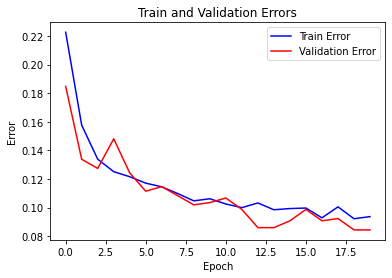

In [13]:
plotError(errors,validAcc)

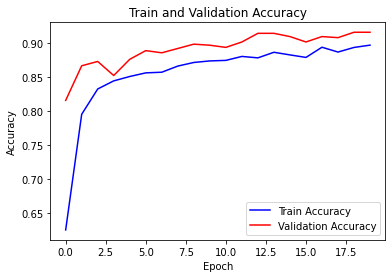

In [14]:
plotAcc(validAcc,trainAcc)

Accuracy:	90.45%
F1 Score:	[0.48780488 0.94878049 0.88940092]


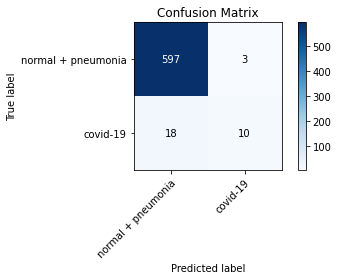

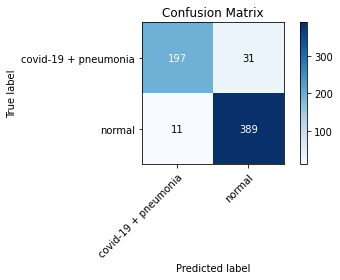

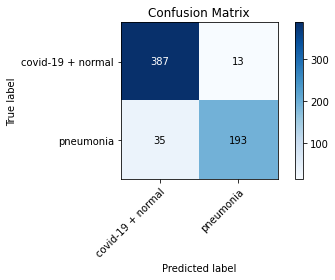

In [17]:
acc, true, pred = accuracy(vgg16,validloader,device)
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

Accuracy:	89.58%
F1 Score:	[0.6025641  0.93618078 0.88390379]


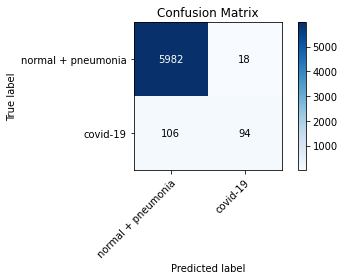

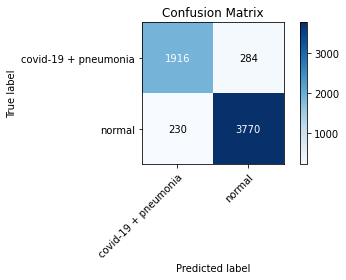

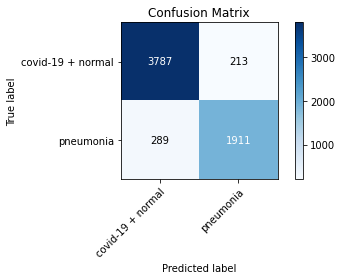

In [18]:
acc, true, pred = accuracy(vgg16,trainloader,device)
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

## VGG16 without Focal Loss

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [0]:
# my roll number's last two digit are 28
noOfNeurons = (28*10)+100
vgg16.classifier = nn.Sequential(nn.Linear(25088, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [0]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)
vgg16.train()
errors, validAcc, trainAcc = train(vgg16, trainloader, validloader, Epochs, criterion, optimizer, device,'vgg16_focal_loss.pth')

cuda:0


Train Epoch: 0 [3080/6200 (112%)]	Loss: 0.426927: : 49it [01:34,  1.93s/it]


Validation Accuracy of the epoch: 0 on the validation images is 0.7961783439490446


Train Epoch: 1 [3080/6200 (112%)]	Loss: 0.314725: : 49it [01:34,  1.93s/it]


Validation Accuracy of the epoch: 1 on the validation images is 0.8535031847133758


Train Epoch: 2 [3080/6200 (112%)]	Loss: 0.226868: : 49it [01:35,  1.95s/it]


Validation Accuracy of the epoch: 2 on the validation images is 0.8678343949044586


Train Epoch: 3 [3080/6200 (112%)]	Loss: 0.351261: : 49it [01:35,  1.95s/it]


Validation Accuracy of the epoch: 3 on the validation images is 0.8885350318471338


Train Epoch: 4 [3080/6200 (112%)]	Loss: 0.317895: : 49it [01:35,  1.94s/it]


Validation Accuracy of the epoch: 4 on the validation images is 0.8853503184713376


Train Epoch: 5 [3080/6200 (112%)]	Loss: 0.195881: : 49it [01:37,  2.00s/it]


Validation Accuracy of the epoch: 5 on the validation images is 0.8869426751592356


Train Epoch: 6 [3080/6200 (112%)]	Loss: 0.190869: : 49it [01:37,  1.99s/it]


Validation Accuracy of the epoch: 6 on the validation images is 0.8853503184713376


Train Epoch: 7 [3080/6200 (112%)]	Loss: 0.173582: : 49it [01:38,  2.01s/it]


Validation Accuracy of the epoch: 7 on the validation images is 0.8885350318471338


Train Epoch: 8 [3080/6200 (112%)]	Loss: 0.248193: : 49it [01:38,  2.01s/it]


Validation Accuracy of the epoch: 8 on the validation images is 0.9012738853503185


Train Epoch: 9 [3080/6200 (112%)]	Loss: 0.175222: : 49it [01:38,  2.01s/it]


Validation Accuracy of the epoch: 9 on the validation images is 0.8996815286624203


Train Epoch: 10 [3080/6200 (112%)]	Loss: 0.312649: : 49it [01:36,  1.98s/it]


Validation Accuracy of the epoch: 10 on the validation images is 0.8980891719745223


Train Epoch: 11 [3080/6200 (112%)]	Loss: 0.152342: : 49it [01:37,  1.99s/it]


Validation Accuracy of the epoch: 11 on the validation images is 0.9028662420382165


Train Epoch: 12 [3080/6200 (112%)]	Loss: 0.188728: : 49it [01:37,  1.98s/it]


Validation Accuracy of the epoch: 12 on the validation images is 0.8901273885350318


Train Epoch: 13 [3080/6200 (112%)]	Loss: 0.096776: : 49it [01:37,  1.99s/it]


Validation Accuracy of the epoch: 13 on the validation images is 0.9028662420382165


Train Epoch: 14 [3080/6200 (112%)]	Loss: 0.222717: : 49it [01:36,  1.96s/it]


Validation Accuracy of the epoch: 14 on the validation images is 0.8964968152866242


Train Epoch: 15 [3080/6200 (112%)]	Loss: 0.112978: : 49it [01:37,  1.99s/it]


Validation Accuracy of the epoch: 15 on the validation images is 0.9060509554140127


Train Epoch: 16 [3080/6200 (112%)]	Loss: 0.175673: : 49it [01:36,  1.97s/it]


Validation Accuracy of the epoch: 16 on the validation images is 0.9124203821656051


Train Epoch: 17 [3080/6200 (112%)]	Loss: 0.161631: : 49it [01:36,  1.96s/it]


Validation Accuracy of the epoch: 17 on the validation images is 0.9060509554140127


Train Epoch: 18 [3080/6200 (112%)]	Loss: 0.266899: : 49it [01:36,  1.97s/it]


Validation Accuracy of the epoch: 18 on the validation images is 0.9140127388535032


Train Epoch: 19 [3080/6200 (112%)]	Loss: 0.163659: : 49it [01:37,  1.99s/it]


Validation Accuracy of the epoch: 19 on the validation images is 0.9124203821656051
Finished Training


In [0]:
acc, true, pred = accuracy(vgg16,validloader,device)

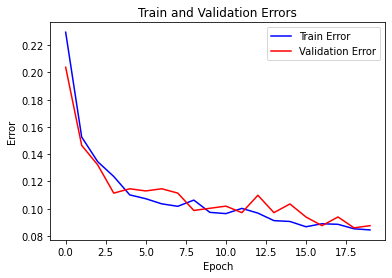

In [0]:
plotError(errors, validAcc)

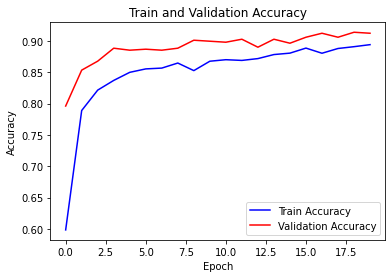

In [0]:
plotAcc(validAcc,trainAcc)

Accuracy:	90.92%
F1 Score:	[0.5       0.9495695 0.9103139]


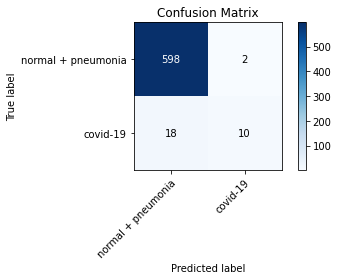

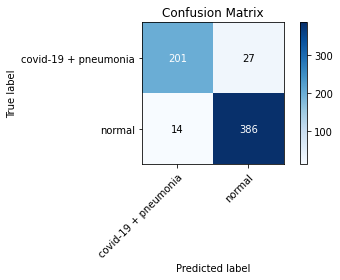

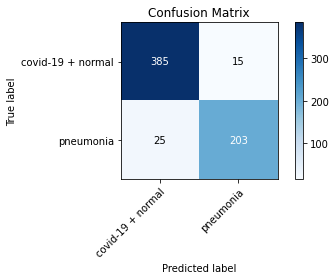

In [0]:
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

In [0]:
acc, true, pred = accuracy(vgg16,trainloader,device)

Accuracy:	89.24%
F1 Score:	[0.50340136 0.93680206 0.87815225]


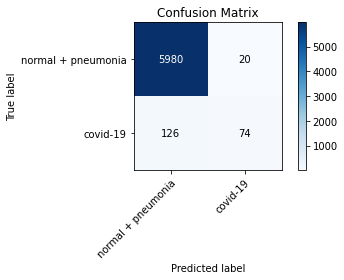

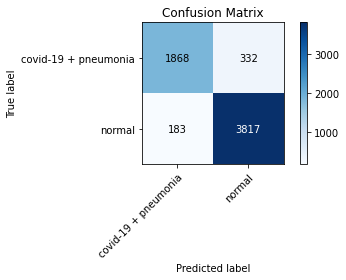

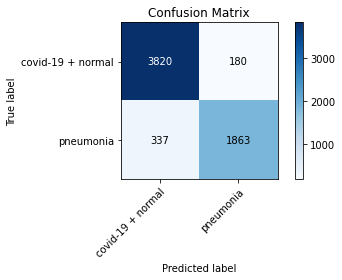

In [0]:
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

## ResNet18 with Focal Loss

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
# print(resnet18)
# print('Output Layer of VGG16 : ', resnet18.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# my roll number's last two digit are 28
noOfNeurons = (28*10)+100
resnet18.fc = nn.Sequential(nn.Linear(512, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [0]:
Epochs = 20
criterion = FocalLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)
resnet18.train()
errors, validAcc, trainAcc = train(resnet18, trainloader, validloader, Epochs, criterion, optimizer, device,'res18_focal_loss.pth')

cuda:0


Train Epoch: 0 [3080/6200 (112%)]	Loss: 0.444090: : 49it [01:26,  1.76s/it]


Validation Accuracy of the epoch: 0 on the validation images is 0.6210191082802548


Train Epoch: 1 [3080/6200 (112%)]	Loss: 0.427410: : 49it [01:27,  1.78s/it]


Validation Accuracy of the epoch: 1 on the validation images is 0.785031847133758


Train Epoch: 2 [3080/6200 (112%)]	Loss: 0.353101: : 49it [01:27,  1.79s/it]


Validation Accuracy of the epoch: 2 on the validation images is 0.8375796178343949


Train Epoch: 3 [3080/6200 (112%)]	Loss: 0.196011: : 49it [01:27,  1.78s/it]


Validation Accuracy of the epoch: 3 on the validation images is 0.8439490445859873


Train Epoch: 4 [3080/6200 (112%)]	Loss: 0.286064: : 49it [01:27,  1.78s/it]


Validation Accuracy of the epoch: 4 on the validation images is 0.8535031847133758


Train Epoch: 5 [3080/6200 (112%)]	Loss: 0.244080: : 49it [01:27,  1.79s/it]


Validation Accuracy of the epoch: 5 on the validation images is 0.8678343949044586


Train Epoch: 6 [3080/6200 (112%)]	Loss: 0.275581: : 49it [01:27,  1.78s/it]


Validation Accuracy of the epoch: 6 on the validation images is 0.8630573248407644


Train Epoch: 7 [3080/6200 (112%)]	Loss: 0.144980: : 49it [01:26,  1.77s/it]


Validation Accuracy of the epoch: 7 on the validation images is 0.8646496815286624


Train Epoch: 8 [3080/6200 (112%)]	Loss: 0.240196: : 49it [01:26,  1.77s/it]


Validation Accuracy of the epoch: 8 on the validation images is 0.8726114649681529


Train Epoch: 9 [3080/6200 (112%)]	Loss: 0.210696: : 49it [01:27,  1.78s/it]


Validation Accuracy of the epoch: 9 on the validation images is 0.8710191082802548


Train Epoch: 10 [3080/6200 (112%)]	Loss: 0.206566: : 49it [01:26,  1.77s/it]


Validation Accuracy of the epoch: 10 on the validation images is 0.8901273885350318


Train Epoch: 11 [3080/6200 (112%)]	Loss: 0.171273: : 49it [01:27,  1.78s/it]


Validation Accuracy of the epoch: 11 on the validation images is 0.89171974522293


Train Epoch: 12 [3080/6200 (112%)]	Loss: 0.341351: : 49it [01:26,  1.77s/it]


Validation Accuracy of the epoch: 12 on the validation images is 0.8980891719745223


Train Epoch: 13 [3080/6200 (112%)]	Loss: 0.149609: : 49it [01:26,  1.76s/it]


Validation Accuracy of the epoch: 13 on the validation images is 0.8885350318471338


Train Epoch: 14 [3080/6200 (112%)]	Loss: 0.178579: : 49it [01:27,  1.78s/it]


Validation Accuracy of the epoch: 14 on the validation images is 0.8901273885350318


Train Epoch: 15 [3080/6200 (112%)]	Loss: 0.208844: : 49it [01:27,  1.79s/it]


Validation Accuracy of the epoch: 15 on the validation images is 0.9076433121019108


Train Epoch: 16 [3080/6200 (112%)]	Loss: 0.139150: : 49it [01:27,  1.80s/it]


Validation Accuracy of the epoch: 16 on the validation images is 0.9028662420382165


Train Epoch: 17 [3080/6200 (112%)]	Loss: 0.148152: : 49it [01:28,  1.81s/it]


Validation Accuracy of the epoch: 17 on the validation images is 0.9060509554140127


Train Epoch: 18 [3080/6200 (112%)]	Loss: 0.173368: : 49it [01:27,  1.79s/it]


Validation Accuracy of the epoch: 18 on the validation images is 0.910828025477707


Train Epoch: 19 [3080/6200 (112%)]	Loss: 0.253020: : 49it [01:27,  1.79s/it]


Validation Accuracy of the epoch: 19 on the validation images is 0.910828025477707
Finished Training


Accuracy:	91.72%
F1 Score:	[0.63636364 0.94919455 0.91150442]


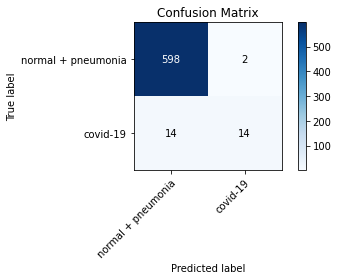

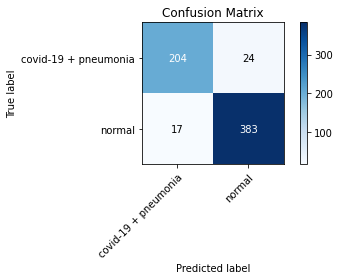

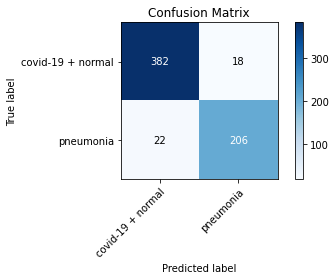

In [0]:
acc, true, pred = accuracy(resnet18,validloader,device)
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

Accuracy:	88.81%
F1 Score:	[0.50704225 0.93203883 0.85490394]


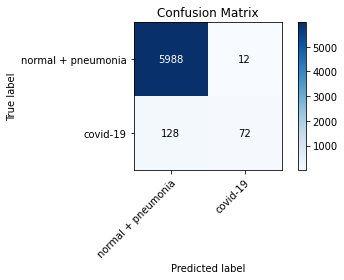

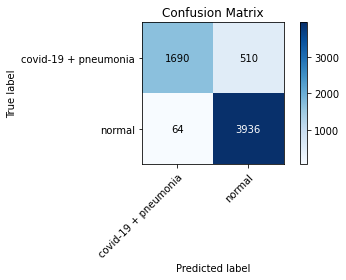

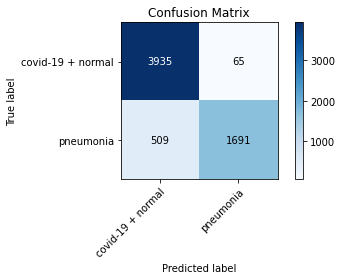

In [0]:
acc, true, pred = accuracy(resnet18,trainloader,device)
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

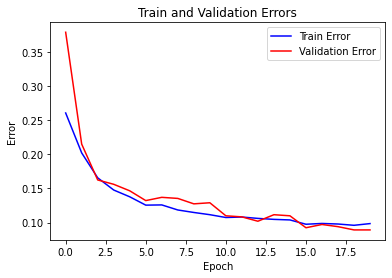

In [0]:
plotError(errors, validAcc)

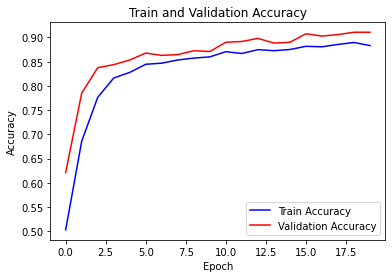

In [0]:
plotAcc(validAcc,trainAcc)

## ResNet18 without Focal Loss

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
# print(resnet18)
# print('Output Layer of VGG16 : ', resnet18.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# my roll number's last two digit are 28
noOfNeurons = (28*10)+100
resnet18.fc = nn.Sequential(nn.Linear(512, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [0]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)
resnet18.train()
errors, validAcc, trainAcc = train(resnet18, trainloader, validloader, Epochs, criterion, optimizer, device,'res18_focal_loss.pth')

cuda:0


Train Epoch: 0 [3080/6200 (112%)]	Loss: 0.400302: : 49it [01:32,  1.89s/it]


Validation Accuracy of the epoch: 0 on the validation images is 0.6289808917197452


Train Epoch: 1 [3080/6200 (112%)]	Loss: 0.401437: : 49it [01:31,  1.86s/it]


Validation Accuracy of the epoch: 1 on the validation images is 0.678343949044586


Train Epoch: 2 [3080/6200 (112%)]	Loss: 0.328797: : 49it [01:30,  1.85s/it]


Validation Accuracy of the epoch: 2 on the validation images is 0.7531847133757962


Train Epoch: 3 [3080/6200 (112%)]	Loss: 0.381270: : 49it [01:30,  1.84s/it]


Validation Accuracy of the epoch: 3 on the validation images is 0.8328025477707006


Train Epoch: 4 [3080/6200 (112%)]	Loss: 0.344336: : 49it [01:31,  1.87s/it]


Validation Accuracy of the epoch: 4 on the validation images is 0.8455414012738853


Train Epoch: 5 [3080/6200 (112%)]	Loss: 0.253691: : 49it [01:32,  1.88s/it]


Validation Accuracy of the epoch: 5 on the validation images is 0.8503184713375797


Train Epoch: 6 [3080/6200 (112%)]	Loss: 0.154047: : 49it [01:31,  1.86s/it]


Validation Accuracy of the epoch: 6 on the validation images is 0.856687898089172


Train Epoch: 7 [3080/6200 (112%)]	Loss: 0.215906: : 49it [01:31,  1.86s/it]


Validation Accuracy of the epoch: 7 on the validation images is 0.8535031847133758


Train Epoch: 8 [3080/6200 (112%)]	Loss: 0.291594: : 49it [01:31,  1.86s/it]


Validation Accuracy of the epoch: 8 on the validation images is 0.8694267515923567


Train Epoch: 9 [3080/6200 (112%)]	Loss: 0.228929: : 49it [01:31,  1.87s/it]


Validation Accuracy of the epoch: 9 on the validation images is 0.8742038216560509


Train Epoch: 10 [3080/6200 (112%)]	Loss: 0.361945: : 49it [01:33,  1.90s/it]


Validation Accuracy of the epoch: 10 on the validation images is 0.8710191082802548


Train Epoch: 11 [3080/6200 (112%)]	Loss: 0.207968: : 49it [01:33,  1.90s/it]


Validation Accuracy of the epoch: 11 on the validation images is 0.8869426751592356


Train Epoch: 12 [3080/6200 (112%)]	Loss: 0.293705: : 49it [01:32,  1.89s/it]


Validation Accuracy of the epoch: 12 on the validation images is 0.8853503184713376


Train Epoch: 13 [3080/6200 (112%)]	Loss: 0.142877: : 49it [01:33,  1.91s/it]


Validation Accuracy of the epoch: 13 on the validation images is 0.8869426751592356


Train Epoch: 14 [3080/6200 (112%)]	Loss: 0.284212: : 49it [01:31,  1.87s/it]


Validation Accuracy of the epoch: 14 on the validation images is 0.8949044585987261


Train Epoch: 15 [3080/6200 (112%)]	Loss: 0.154896: : 49it [01:31,  1.87s/it]


Validation Accuracy of the epoch: 15 on the validation images is 0.8869426751592356


Train Epoch: 16 [3080/6200 (112%)]	Loss: 0.318046: : 49it [01:32,  1.88s/it]


Validation Accuracy of the epoch: 16 on the validation images is 0.8949044585987261


Train Epoch: 17 [3080/6200 (112%)]	Loss: 0.262818: : 49it [01:32,  1.90s/it]


Validation Accuracy of the epoch: 17 on the validation images is 0.893312101910828


Train Epoch: 18 [3080/6200 (112%)]	Loss: 0.138132: : 49it [01:31,  1.87s/it]


Validation Accuracy of the epoch: 18 on the validation images is 0.8885350318471338


Train Epoch: 19 [3080/6200 (112%)]	Loss: 0.238110: : 49it [01:32,  1.89s/it]


Validation Accuracy of the epoch: 19 on the validation images is 0.8949044585987261
Finished Training


Accuracy:	89.17%
F1 Score:	[0.         0.93913043 0.89135255]


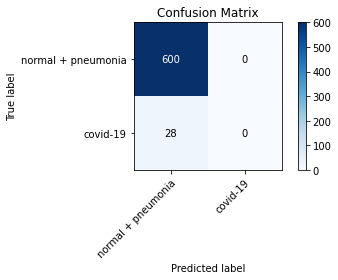

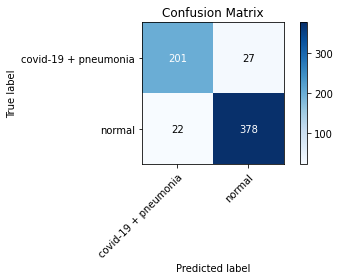

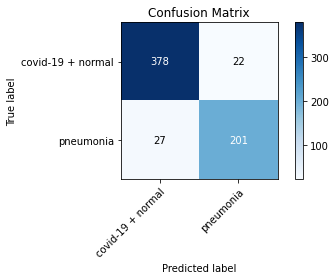

In [0]:
acc, true, pred = accuracy(resnet18,validloader,device)
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

Accuracy:	87.92%
F1 Score:	[0.         0.93164557 0.86138855]


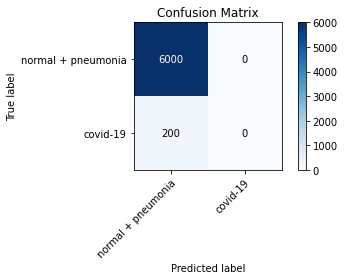

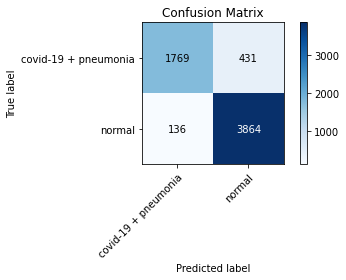

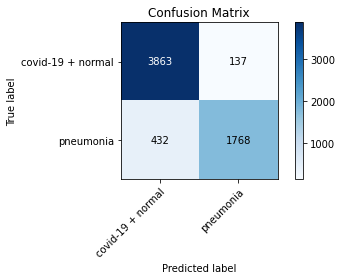

In [0]:
acc, true, pred = accuracy(resnet18,trainloader,device)
print(f'Accuracy:\t{np.round(acc*100,2)}%')
f1 = f1_score(true.to("cpu"), pred.to("cpu"), average=None)
print(f'F1 Score:\t{f1}')
plot_confusion_matrix(true.to('cpu').numpy(), pred.to('cpu').numpy(),class_names)

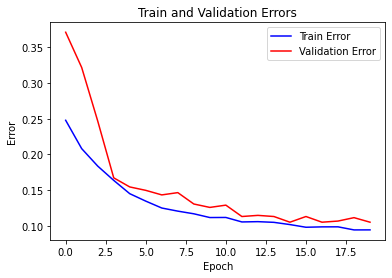

In [0]:
plotError(errors,validAcc)

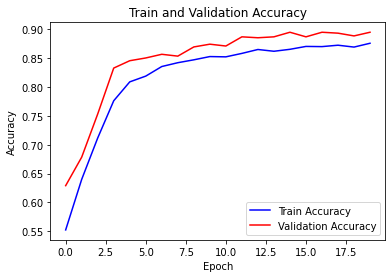

In [0]:
plotAcc(validAcc,trainAcc)